import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

import category_encoders as ce
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import lightgbm as gbm


pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 30)

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('train shape', train.shape)
print('test shape' , test.shape)
train

train shape (207, 12)
test shape (40, 11)


,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
0,2013-11-18,90,月,0,厚切りイカフライ,NaN,NaN,NaN,NaN,快晴,--,19.8
1,2013-11-19,101,火,1,手作りヒレカツ,NaN,NaN,NaN,NaN,快晴,--,17.0
2,2013-11-20,118,水,0,白身魚唐揚げ野菜あん,NaN,NaN,NaN,NaN,快晴,--,15.5
3,2013-11-21,120,木,1,若鶏ピリ辛焼,NaN,NaN,NaN,NaN,快晴,--,15.2
4,2013-11-22,130,金,1,ビッグメンチカツ,NaN,NaN,NaN,NaN,快晴,--,16.1
...,...,...,...,...,...,...,...,...,...,...,...,...
202,2014-9-24,59,水,1,白身魚のマスタード焼き,408.0,NaN,NaN,NaN,曇,0,24.8
203,2014-9-25,50,木,0,牛カルビ焼き肉,394.0,NaN,NaN,NaN,曇,0,25.4
204,2014-9-26,45,金,0,ランチビュッフェ,NaN,スペシャルメニュー（800円）,キャリアアップ支援セミナー,NaN,晴れ,--,27.1
205,2014-9-29,56,月,1,豚肉と玉子の炒め,404.0,NaN,NaN,NaN,快晴,--,26.6


## 仮置 いろいろ関数

In [3]:


# category_encoding関数
def encoding_func(df, encoding_col_name_list):
    def which_col_is_object_func(df):
        # 列がobjectを抽出してリストに
        keys = list(df.dtypes.loc[df.dtypes == 'object'].index)
        # 辞書化
        values = list(range(len(object_list)))
        object_dic = dict(zip(keys, values))
        print(object_dic)
    
    
    # カテゴリエンコーダーする
    ce_oe = ce.OrdinalEncoder(cols = encoding_col_name_list, handle_unknown = 'impute')
    df = ce_oe.fit_transform(df)

    # カテゴリ番号の確認
    
    for i in range(len(encoding_col_name_list)):
        print(pd.DataFrame(ce_oe.category_mapping[i]))
        print()
    return df


# 休日前flg (category encodingのあとにやる)
def before_holiday_func(df):
    df['before_holiday'] = 0
    for i in range(len(df)):
        
        if df['week'].diff(-1).iloc[i] == -1.0:
            df['before_holiday'].iloc[i] = 0        
        
        elif i == len(df):
            df['before_holiday'].iloc[i] = 0
        
        else:
            df['before_holiday'].iloc[i] = 1

# 休日後flg (category encodingのあとにやる)
def after_holiday_func(df):
    df['after_holiday'] = 0

    for i in range(len(df)):
        if i == 1:
            df['week'].iloc[i] == 1
            
        elif df['week'].diff(1).iloc[i] == 1.0:
            df['after_holiday'].iloc[i] = 0
            
        else:
            df['after_holiday'].iloc[i] = 1

# 前処理

In [4]:
# trainとtestの識別列を追加
train['train_flg'] = True
test['train_flg'] = False

# データの結合
all_data = pd.concat([train, test], axis = 0)

# NaNの穴埋め
all_data['payday'] = all_data['payday'].fillna(0)
all_data['remarks'] = all_data['remarks'].fillna(0)
all_data['event'] = all_data['event'].fillna(0)

# 降水量の--の処理。
'''
降水量０ｍｍは0.5mm未満のことであるため、雨は降っている。
一方で'--'は雨が降っていない。なので、明確に識別することが必要
ここでは、--を−１に置き換えてみる。
'''

all_data['precipitation'] = all_data['precipitation'].apply(lambda x : -1 if x == '--' else float(x))


# kcalの処理 とりあえず中央値で埋める
all_data['kcal'] = all_data['kcal'].fillna(all_data['kcal'].median())

# メニューの処理
# カレー最強
all_data['curry'] = all_data['name'].apply(lambda x : 1 if 'カレー' in x else 0)
all_data['menchikatsu'] = all_data['name'].apply(lambda x : 1 if 'メンチカツ' in x else 0)

### 作った関数を使って前処理していく

# 各種データの変換
all_data['datetime'] = pd.to_datetime(all_data['datetime'])

# encoding
encoding_col_name_list = ['week',
                         'remarks',
                         'event',
                         'weather']

all_data = encoding_func(all_data, encoding_col_name_list)

# 祝日前後の平日にflg
after_holiday_func(all_data)
before_holiday_func(all_data)

# train と testにもどす。
df_train = all_data.loc[all_data['train_flg'] == True]
df_test = all_data.loc[all_data['train_flg'] == False]

/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


      col  mapping data_type
月    week        1    object
火    week        2    object
水    week        3    object
木    week        4    object
金    week        5    object
NaN  week       -2    object

                              col  mapping data_type
0                         remarks        1    object
鶏のレモンペッパー焼（50食）、カレー（42食）  remarks        2    object
酢豚（28食）、カレー（85食）          remarks        3    object
お楽しみメニュー                  remarks        4    object
料理長のこだわりメニュー              remarks        5    object
手作りの味                     remarks        6    object
スペシャルメニュー（800円）           remarks        7    object
近隣に飲食店複合ビルオープン            remarks        8    object
NaN                       remarks       -2    object

                 col  mapping data_type
0              event        1    object
ママの会           event        2    object
キャリアアップ支援セミナー  event        3    object
NaN            event       -2    object

         col  mapping data_type
快晴   weather        1    object


In [5]:
all_data

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature,train_flg,curry,menchikatsu,after_holiday,before_holiday
0,2013-11-18,90.0,1,0,厚切りイカフライ,412.0,1,1,0.0,1,-1.0,19.8,True,0,0,1,0
1,2013-11-19,101.0,2,1,手作りヒレカツ,412.0,1,1,0.0,1,-1.0,17.0,True,0,0,0,0
2,2013-11-20,118.0,3,0,白身魚唐揚げ野菜あん,412.0,1,1,0.0,1,-1.0,15.5,True,0,0,0,0
3,2013-11-21,120.0,4,1,若鶏ピリ辛焼,412.0,1,1,0.0,1,-1.0,15.2,True,0,0,0,0
4,2013-11-22,130.0,5,1,ビッグメンチカツ,412.0,1,1,0.0,1,-1.0,16.1,True,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,2014-11-21,NaN,5,0,ロコモコ丼,412.0,4,1,0.0,1,-1.0,14.9,False,0,0,0,1
36,2014-11-25,NaN,2,1,なすと挽肉のはさみ揚げ,460.0,1,1,0.0,5,1.5,11.4,False,0,0,1,0
37,2014-11-26,NaN,3,1,鶏肉の治部煮風,415.0,1,1,0.0,5,1.0,9.2,False,0,0,0,0
38,2014-11-27,NaN,4,0,牛丼風,420.0,1,1,0.0,1,-1.0,15.1,False,0,0,0,0


# ECA

In [6]:
df_train['name'].unique(), len(df_train['name'])

(array(['厚切りイカフライ', '手作りヒレカツ', '白身魚唐揚げ野菜あん', '若鶏ピリ辛焼', 'ビッグメンチカツ', '鶏の唐揚',
        '豚のスタミナ炒め', 'ボローニャ風カツ', 'ハンバーグ', 'タルタルinソーセージカツ', 'マーボ豆腐',
        '厚揚げ豚生姜炒め', 'クリームチーズ入りメンチ', '鶏のカッシュナッツ炒め', '手作りロースカツ',
        'ハンバーグデミソース', 'やわらかロースのサムジョン', '五目御飯', '肉じゃが', 'タンドリーチキン',
        'カキフライタルタル', '回鍋肉', 'ポーク味噌焼き', '鶏の唐揚げ甘酢あん', 'さっくりメンチカツ',
        '手ごね風ハンバーグ', '酢豚', 'カレー入りソーセージカツ', '豚肉の生姜焼', '鶏チリソース',
        '鶏の照り焼きマスタード', 'さんま辛味焼', 'カレイ唐揚げ野菜あんかけ', 'ジューシーメンチカツ', 'サバ焼味噌掛け',
        '手作りひれかつとカレー', '鶏のレモンペッパー焼orカレー', 'チンジャオロース', '海老フライタルタル',
        'チーズ入りメンチカツ', '鶏の唐揚げ', 'メダイ照り焼', 'ハンバーグカレーソース', 'さわら焼味噌掛け',
        '鶏のピリ辛焼き', 'ホタテクリ―ムシチュー', '鶏の唐揚げおろしソース', 'ますのマスタードソース', 'ロース甘味噌焼き',
        '海老フライとホタテ串カツ', 'ハンバーグ和風きのこソース', '酢豚orカレー', 'ポークハヤシ',
        '白身魚唐揚げ野菜あんかけ', '手作りひれかつ', 'メンチカツ', 'チキンクリームシチュー', '海老クリーミ―クノーデル',
        'ビーフカレー', 'カレイ野菜あんかけ', 'チーズ入りハンバーグ', '越冬キャベツのメンチカツ', '鶏の親子煮',
        '肉団子クリームシチュー', 'キーマカレー', '青椒肉絲', '和風ソースハンバーグ', '青梗菜牛肉炒め',
        '肉団子のシチュー', 'チキンカレー', 'ビーフトマト煮', '

In [7]:
df_train.groupby(['soldout']).count()

,datetime,y,week,name,kcal,remarks,event,payday,weather,precipitation,temperature,train_flg,curry,menchikatsu,after_holiday,before_holiday
soldout,,,,,,,,,,,,,,,,
0,114,114,114,114,114,114,114,114,114,114,114,114,114,114,114,114
1,93,93,93,93,93,93,93,93,93,93,93,93,93,93,93,93


### 販売個数が多い順で、売り切れたもの
- 販売個数が減少傾向があるので、販売個数が多い順でみちゃうと定量的に見れていないのでは?  

  直近○○日以内の平均、標準偏差と比較して多いかどうか で考えたほうがよさそう

In [8]:
df_train.sort_values(by = 'y', ascending = False).loc[df_train['soldout'] == 1].head(20)

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature,train_flg,curry,menchikatsu,after_holiday,before_holiday
15,2013-12-09,165.0,1,1,ハンバーグデミソース,412.0,1,1,0.0,2,-1.0,9.1,True,0,0,1,0
11,2013-12-03,153.0,2,1,厚揚げ豚生姜炒め,412.0,1,1,0.0,1,-1.0,13.9,True,0,0,0,0
12,2013-12-04,151.0,3,1,クリームチーズ入りメンチ,412.0,1,1,0.0,3,-1.0,13.5,True,0,0,0,0
10,2013-12-02,151.0,1,1,マーボ豆腐,412.0,1,1,0.0,1,-1.0,13.8,True,0,0,1,0
22,2013-12-18,145.0,3,1,回鍋肉,412.0,1,1,0.0,2,-1.0,7.8,True,0,0,0,0
7,2013-11-27,140.0,3,1,ボローニャ風カツ,412.0,1,1,0.0,3,-1.0,14.7,True,0,0,0,0
46,2014-02-03,139.0,1,1,ハンバーグカレーソース,445.0,1,1,0.0,3,-1.0,15.9,True,1,0,1,0
55,2014-02-17,137.0,1,1,チンジャオロース,416.0,1,1,0.0,3,-1.0,11.6,True,0,0,1,0
5,2013-11-25,135.0,1,1,鶏の唐揚,412.0,1,1,0.0,2,-1.0,14.6,True,0,0,1,0
24,2013-12-20,134.0,5,1,鶏の唐揚げ甘酢あん,412.0,1,1,0.0,2,-1.0,8.4,True,0,0,0,1


## 販売量の推移
突発的に売れるメニューもあるが、全体的には現象傾向

<AxesSubplot:xlabel='datetime', ylabel='y'>

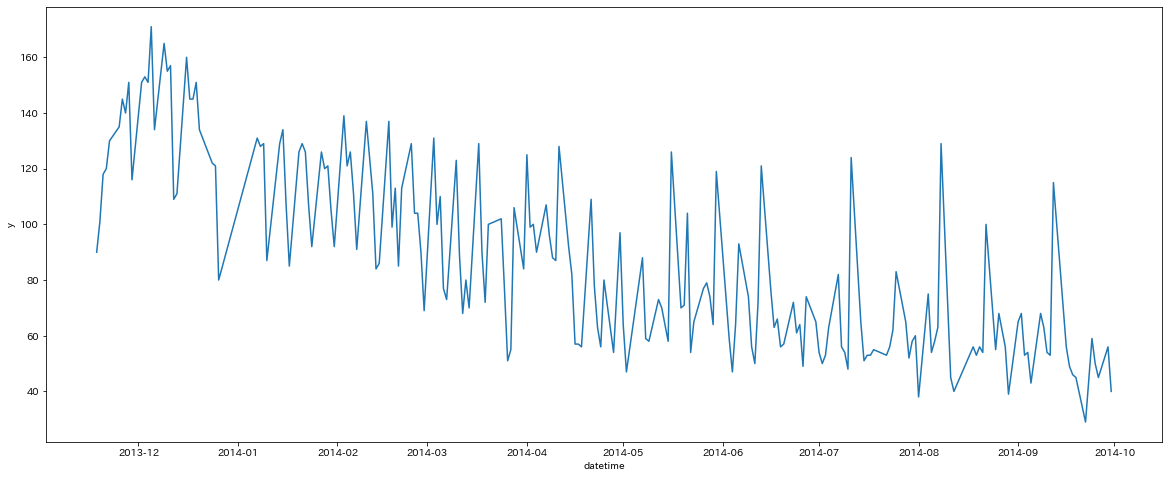

In [9]:
plt.figure(figsize = (20,8))
sns.lineplot(x = 'datetime', y = 'y', data = df_train)

<ipython-input-10-671a9301b5d0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['YM'] = df_train['datetime'].dt.strftime('%Y%m')


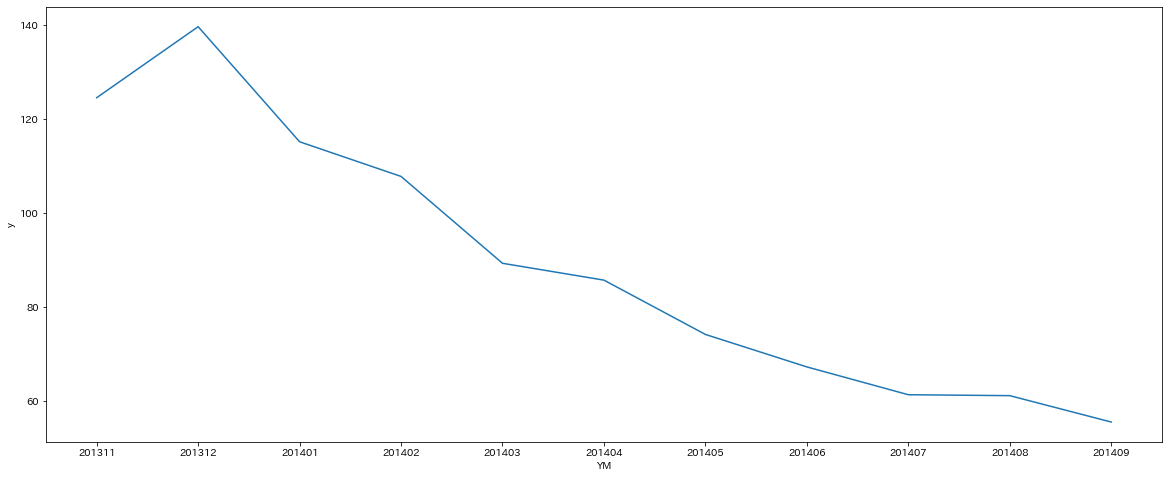

In [10]:
# 年月列を追加
df_train['YM'] = df_train['datetime'].dt.strftime('%Y%m')

# 月ごとの平均
df_train_ym = df_train.groupby(df_train['YM'], as_index = False).mean()

plt.figure(figsize = (20,8))
sns.lineplot(x = 'YM', y = 'y', data = df_train_ym)
plt.show()


### 移動平均等

<ipython-input-11-4cdc0d05c4cc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y_rolling_mean5'] = df_train['y'].rolling(5).mean()


<AxesSubplot:xlabel='datetime', ylabel='y_rolling_mean5'>

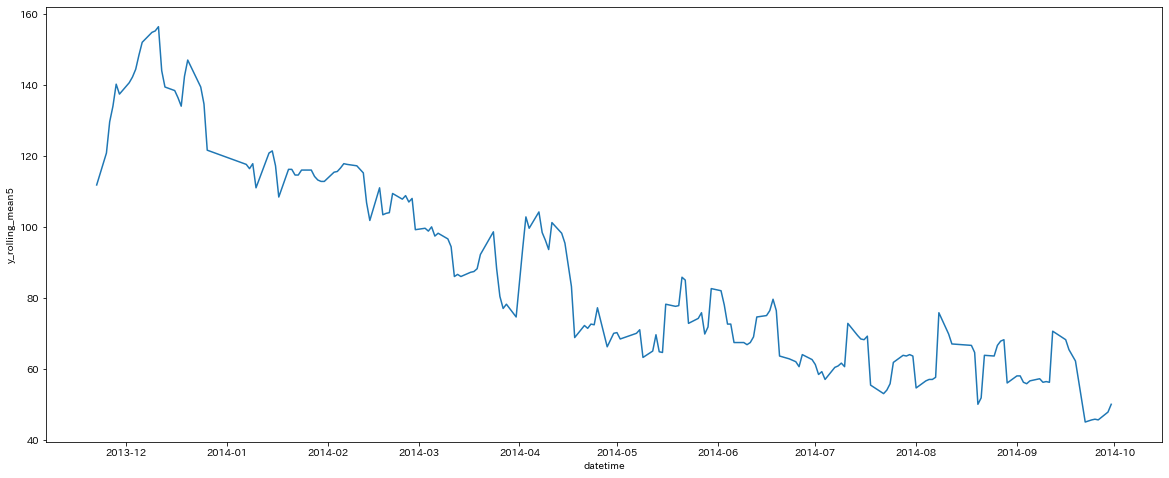

In [11]:
df_train['y_rolling_mean5'] = df_train['y'].rolling(5).mean()
plt.figure(figsize = (20,8))
sns.lineplot(x = 'datetime', y = 'y_rolling_mean5', data = df_train)

### 変化率、変化量

#### 変化量

In [12]:
y_pct_change_N = 5

for i in range(1, y_pct_change_N + 1):
    df_train['y_pct_change_' + str(i)] = df_train['y'].pct_change(i)
df_train

<ipython-input-12-50107186c40c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y_pct_change_' + str(i)] = df_train['y'].pct_change(i)


,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature,train_flg,curry,menchikatsu,after_holiday,before_holiday,YM,y_rolling_mean5,y_pct_change_1,y_pct_change_2,y_pct_change_3,y_pct_change_4,y_pct_change_5
0,2013-11-18,90.0,1,0,厚切りイカフライ,412.0,1,1,0.0,1,-1.0,19.8,True,0,0,1,0,201311,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-11-19,101.0,2,1,手作りヒレカツ,412.0,1,1,0.0,1,-1.0,17.0,True,0,0,0,0,201311,NaN,0.122222,NaN,NaN,NaN,NaN
2,2013-11-20,118.0,3,0,白身魚唐揚げ野菜あん,412.0,1,1,0.0,1,-1.0,15.5,True,0,0,0,0,201311,NaN,0.168317,0.311111,NaN,NaN,NaN
3,2013-11-21,120.0,4,1,若鶏ピリ辛焼,412.0,1,1,0.0,1,-1.0,15.2,True,0,0,0,0,201311,NaN,0.016949,0.188119,0.333333,NaN,NaN
4,2013-11-22,130.0,5,1,ビッグメンチカツ,412.0,1,1,0.0,1,-1.0,16.1,True,0,1,0,1,201311,111.8,0.083333,0.101695,0.287129,0.444444,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,2014-09-24,59.0,3,1,白身魚のマスタード焼き,408.0,1,1,0.0,2,0.0,24.8,True,0,0,1,0,201409,45.6,1.034483,0.311111,0.282609,0.204082,0.053571
203,2014-09-25,50.0,4,0,牛カルビ焼き肉,394.0,1,1,0.0,2,0.0,25.4,True,0,0,0,0,201409,45.8,-0.152542,0.724138,0.111111,0.086957,0.020408
204,2014-09-26,45.0,5,0,ランチビュッフェ,412.0,7,3,0.0,3,-1.0,27.1,True,0,0,0,1,201409,45.6,-0.100000,-0.237288,0.551724,0.000000,-0.021739
205,2014-09-29,56.0,1,1,豚肉と玉子の炒め,404.0,1,1,0.0,1,-1.0,26.6,True,0,0,1,0,201409,47.8,0.244444,0.120000,-0.050847,0.931034,0.244444


<AxesSubplot:xlabel='datetime', ylabel='y_pct_change_5'>

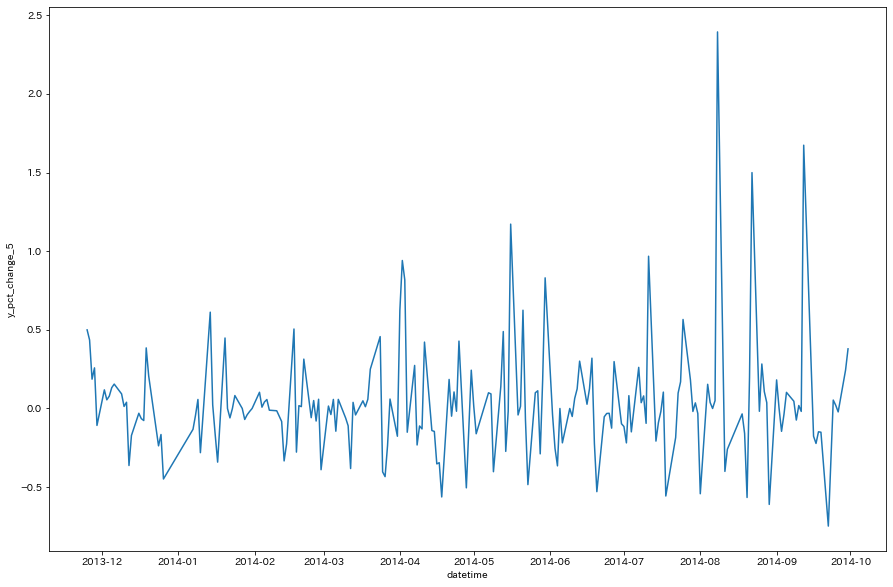

In [13]:
plt.figure(figsize = (15,10))
sns.lineplot(x = 'datetime', y = 'y_pct_change_5', data = df_train)

### 人気メニューの確認
いや、これみたいの見れてない気がするな。 　
→pct_changeでどっちも人気メニューのカレーでの変化率は小さくなるが、どっちも多分人気メニューのはず。  

人気メニューの定義は？

In [14]:
# ｐｃｔ
df_train.sort_values(by = 'y_pct_change_5', ascending = False)
df_train.sort_values(by = 'y_pct_change_5', ascending = False).to_csv('y_pct_change_5.csv')

週ごとの一番うれたやつをピックアップ

In [15]:
df_train

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature,train_flg,curry,menchikatsu,after_holiday,before_holiday,YM,y_rolling_mean5,y_pct_change_1,y_pct_change_2,y_pct_change_3,y_pct_change_4,y_pct_change_5
0,2013-11-18,90.0,1,0,厚切りイカフライ,412.0,1,1,0.0,1,-1.0,19.8,True,0,0,1,0,201311,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-11-19,101.0,2,1,手作りヒレカツ,412.0,1,1,0.0,1,-1.0,17.0,True,0,0,0,0,201311,NaN,0.122222,NaN,NaN,NaN,NaN
2,2013-11-20,118.0,3,0,白身魚唐揚げ野菜あん,412.0,1,1,0.0,1,-1.0,15.5,True,0,0,0,0,201311,NaN,0.168317,0.311111,NaN,NaN,NaN
3,2013-11-21,120.0,4,1,若鶏ピリ辛焼,412.0,1,1,0.0,1,-1.0,15.2,True,0,0,0,0,201311,NaN,0.016949,0.188119,0.333333,NaN,NaN
4,2013-11-22,130.0,5,1,ビッグメンチカツ,412.0,1,1,0.0,1,-1.0,16.1,True,0,1,0,1,201311,111.8,0.083333,0.101695,0.287129,0.444444,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,2014-09-24,59.0,3,1,白身魚のマスタード焼き,408.0,1,1,0.0,2,0.0,24.8,True,0,0,1,0,201409,45.6,1.034483,0.311111,0.282609,0.204082,0.053571
203,2014-09-25,50.0,4,0,牛カルビ焼き肉,394.0,1,1,0.0,2,0.0,25.4,True,0,0,0,0,201409,45.8,-0.152542,0.724138,0.111111,0.086957,0.020408
204,2014-09-26,45.0,5,0,ランチビュッフェ,412.0,7,3,0.0,3,-1.0,27.1,True,0,0,0,1,201409,45.6,-0.100000,-0.237288,0.551724,0.000000,-0.021739
205,2014-09-29,56.0,1,1,豚肉と玉子の炒め,404.0,1,1,0.0,1,-1.0,26.6,True,0,0,1,0,201409,47.8,0.244444,0.120000,-0.050847,0.931034,0.244444


In [16]:
ddf = df_train.groupby('W')
df_train_week_max = df_train.loc[ddf['y'].idxmax()]
df_train_week_max.sort_values(by = 'datetime', inplace = True)
df_train_week_max.to_csv('週ごとの売れ行き一位.csv')

KeyError: 'W'

In [ ]:
df_train_week_max

### カレーとメンチカツ強そうなので、フラグを立てる。

In [17]:
df_train['curry'] = df_train['name'].apply(lambda x : 1 if 'カレー' in x else 0 )
df_train.head(30)


<ipython-input-17-3bb97c3bf546>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['curry'] = df_train['name'].apply(lambda x : 1 if 'カレー' in x else 0 )


,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature,train_flg,curry,menchikatsu,after_holiday,before_holiday,YM,y_rolling_mean5,y_pct_change_1,y_pct_change_2,y_pct_change_3,y_pct_change_4,y_pct_change_5
0,2013-11-18,90.0,1,0,厚切りイカフライ,412.0,1,1,0.0,1,-1.0,19.8,True,0,0,1,0,201311,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-11-19,101.0,2,1,手作りヒレカツ,412.0,1,1,0.0,1,-1.0,17.0,True,0,0,0,0,201311,NaN,0.122222,NaN,NaN,NaN,NaN
2,2013-11-20,118.0,3,0,白身魚唐揚げ野菜あん,412.0,1,1,0.0,1,-1.0,15.5,True,0,0,0,0,201311,NaN,0.168317,0.311111,NaN,NaN,NaN
3,2013-11-21,120.0,4,1,若鶏ピリ辛焼,412.0,1,1,0.0,1,-1.0,15.2,True,0,0,0,0,201311,NaN,0.016949,0.188119,0.333333,NaN,NaN
4,2013-11-22,130.0,5,1,ビッグメンチカツ,412.0,1,1,0.0,1,-1.0,16.1,True,0,1,0,1,201311,111.8,0.083333,0.101695,0.287129,0.444444,NaN
5,2013-11-25,135.0,1,1,鶏の唐揚,412.0,1,1,0.0,2,-1.0,14.6,True,0,0,1,0,201311,120.8,0.038462,0.125000,0.144068,0.336634,0.500000
6,2013-11-26,145.0,2,0,豚のスタミナ炒め,412.0,1,1,0.0,1,-1.0,17.9,True,0,0,0,0,201311,129.6,0.074074,0.115385,0.208333,0.228814,0.435644
7,2013-11-27,140.0,3,1,ボローニャ風カツ,412.0,1,1,0.0,3,-1.0,14.7,True,0,0,0,0,201311,134.0,-0.034483,0.037037,0.076923,0.166667,0.186441
8,2013-11-28,151.0,4,0,ハンバーグ,412.0,1,1,0.0,4,-1.0,17.7,True,0,0,0,0,201311,140.2,0.078571,0.041379,0.118519,0.161538,0.258333
9,2013-11-29,116.0,5,0,タルタルinソーセージカツ,412.0,1,1,0.0,1,-1.0,12.1,True,0,0,0,1,201311,137.4,-0.231788,-0.171429,-0.200000,-0.140741,-0.107692


# lightgbm 

In [18]:
df_train

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature,train_flg,curry,menchikatsu,after_holiday,before_holiday,YM,y_rolling_mean5,y_pct_change_1,y_pct_change_2,y_pct_change_3,y_pct_change_4,y_pct_change_5
0,2013-11-18,90.0,1,0,厚切りイカフライ,412.0,1,1,0.0,1,-1.0,19.8,True,0,0,1,0,201311,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-11-19,101.0,2,1,手作りヒレカツ,412.0,1,1,0.0,1,-1.0,17.0,True,0,0,0,0,201311,NaN,0.122222,NaN,NaN,NaN,NaN
2,2013-11-20,118.0,3,0,白身魚唐揚げ野菜あん,412.0,1,1,0.0,1,-1.0,15.5,True,0,0,0,0,201311,NaN,0.168317,0.311111,NaN,NaN,NaN
3,2013-11-21,120.0,4,1,若鶏ピリ辛焼,412.0,1,1,0.0,1,-1.0,15.2,True,0,0,0,0,201311,NaN,0.016949,0.188119,0.333333,NaN,NaN
4,2013-11-22,130.0,5,1,ビッグメンチカツ,412.0,1,1,0.0,1,-1.0,16.1,True,0,1,0,1,201311,111.8,0.083333,0.101695,0.287129,0.444444,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,2014-09-24,59.0,3,1,白身魚のマスタード焼き,408.0,1,1,0.0,2,0.0,24.8,True,0,0,1,0,201409,45.6,1.034483,0.311111,0.282609,0.204082,0.053571
203,2014-09-25,50.0,4,0,牛カルビ焼き肉,394.0,1,1,0.0,2,0.0,25.4,True,0,0,0,0,201409,45.8,-0.152542,0.724138,0.111111,0.086957,0.020408
204,2014-09-26,45.0,5,0,ランチビュッフェ,412.0,7,3,0.0,3,-1.0,27.1,True,0,0,0,1,201409,45.6,-0.100000,-0.237288,0.551724,0.000000,-0.021739
205,2014-09-29,56.0,1,1,豚肉と玉子の炒め,404.0,1,1,0.0,1,-1.0,26.6,True,0,0,1,0,201409,47.8,0.244444,0.120000,-0.050847,0.931034,0.244444


In [6]:
df_X = df_train.drop(columns = ['datetime', 'name', 'y', 'train_flg'])
df_y = df_train['y']

In [7]:
df_y

0       90.0
1      101.0
2      118.0
3      120.0
4      130.0
       ...  
202     59.0
203     50.0
204     45.0
205     56.0
206     40.0
Name: y, Length: 207, dtype: float64

In [8]:
folds = TimeSeriesSplit(n_splits = 5)

params = {
    'boosting_type' : 'gbdt',
    'objective' : 'regression',
    'metric' : 'rmse',
    'max_depth' : 9,
        }


train_score = []
valid_score = []
models = []


for i, (train_index, valid_index) in enumerate(folds.split(df_train)):
    
    X_train, X_valid = df_X.iloc[train_index], df_X.iloc[valid_index]
    y_train, y_valid = df_y[train_index], df_y[valid_index]
    
    train_data = gbm.Dataset(X_train, y_train)
    valid_data = gbm.Dataset(X_valid, y_valid, reference = train_data)
    
    print('-------------------------------')
    print('model No: ', i)
    
    model = gbm.train(params,
                    train_data,
                    valid_sets = [train_data,valid_data],
                    num_boost_round = 10000,
                    early_stopping_rounds = 10,
                    verbose_eval = 50
                    )
    
    # モデル評価
    # trainのモデル評価
    train_pred = model.predict(X_train)# arrayで返ってくる。値は確率
    train_pred_vs_data_df = pd.concat([y_train, pd.Series(train_pred,index = train_index)],
                                      axis = 1)# 真値と予測値のｄｆ作成
    train_pred_vs_data_df.columns = ['true','pred']
    
    # validのモデル評価
    valid_pred = model.predict(X_valid)
    valid_pred_vs_data_df = pd.concat([y_valid, pd.Series(valid_pred, index = valid_index)],axis = 1)
    valid_pred_vs_data_df.columns = ['true','pred']
    
    train_score.append(np.sqrt(mean_squared_error(train_pred_vs_data_df['true'],train_pred_vs_data_df['pred'])))
    valid_score.append(np.sqrt(mean_squared_error(valid_pred_vs_data_df['true'],valid_pred_vs_data_df['pred'])))
    
    models.append(model)
    
   

-------------------------------
model No:  0
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 37, number of used features: 0
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 130.189189
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped t

In [ ]:
train_score

In [ ]:
valid_score

In [22]:
x_train = df_X.iloc[train_index]
x_valid = df_X.iloc[valid_index]
y_train = df_y

,week,soldout,kcal,remarks,event,payday,weather,precipitation,temperature,curry,menchikatsu,after_holiday,before_holiday,YM,y_rolling_mean5,y_pct_change_1,y_pct_change_2,y_pct_change_3,y_pct_change_4,y_pct_change_5
0,1,0,412.0,1,1,0.0,1,-1.0,19.8,0,0,1,0,201311,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,412.0,1,1,0.0,1,-1.0,17.0,0,0,0,0,201311,NaN,0.122222,NaN,NaN,NaN,NaN
2,3,0,412.0,1,1,0.0,1,-1.0,15.5,0,0,0,0,201311,NaN,0.168317,0.311111,NaN,NaN,NaN
3,4,1,412.0,1,1,0.0,1,-1.0,15.2,0,0,0,0,201311,NaN,0.016949,0.188119,0.333333,NaN,NaN
4,5,1,412.0,1,1,0.0,1,-1.0,16.1,0,1,0,1,201311,111.8,0.083333,0.101695,0.287129,0.444444,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,2,1,376.0,1,1,0.0,3,-1.0,5.8,0,0,1,0,201401,120.8,0.482759,0.000000,0.007812,-0.015267,0.612500
33,3,0,450.0,1,1,0.0,2,-1.0,2.9,0,0,0,0,201401,121.4,0.038760,0.540230,0.038760,0.046875,0.022901
34,4,0,415.0,1,1,0.0,1,-1.0,7.0,0,0,0,0,201401,117.2,-0.201493,-0.170543,0.229885,-0.170543,-0.164062
35,5,1,430.0,1,2,0.0,1,-1.0,7.8,0,0,0,1,201401,108.4,-0.205607,-0.365672,-0.341085,-0.022989,-0.341085


In [24]:
train_index, valid_index

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36]),
 array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]))

# testデータで

In [125]:
#全部のデータを学習に使う

In [136]:
df_test_X = df_test.drop(columns = ['datetime', 'name', 'y', 'train_flg'])
df_test_y = df_test[['datetime', 'y']]

In [137]:
submit_model = models[4]

df_test_y['y'] = submit_model.predict(df_test_X)
df_test_y

<ipython-input-137-520f16082398>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_y['y'] = submit_model.predict(df_test_X)


,datetime,y
0,2014-10-01,74.177450
1,2014-10-02,66.038352
2,2014-10-03,56.852867
3,2014-10-06,71.161787
4,2014-10-07,64.512848
...,...,...
35,2014-11-21,124.827140
36,2014-11-25,130.434568
37,2014-11-26,117.437822
38,2014-11-27,99.325451


### datetime型を提出書式に変換

In [141]:
df_test_y.to_csv('submit.csv',index = False, header = False)